In [82]:
import torch
from torch import nn, optim
import torch.nn as nn
from torch.nn import MSELoss, CrossEntropyLoss
import torch.nn.functional as F
from torch.optim import SGD
from torch.utils.data import Dataset, DataLoader
import albumentations as A
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from typing import Tuple
import pandas as pd
import os
import cv2

# Define all constants
MEAN = (0.4016, 0.3890, 0.3861)
STD = (0.3087, 0.3065, 0.3118)
HEIGHT = 128
WIDTH = 128
BATCH_SIZE = 32
NUM_EPOCHS = 10
BEST_MODEL_PATH = 'best_model.pth'

In [83]:
class AlbumentationsTransform:
  """A class to make Albumentations compatible with built-in torchvision Datasets.

  This class takes an Albumentations transformation as input and makes it
  behaive astorchvision Transform objects. Note that if you are using your own
  dataset, this is not needed.

  Attributes:
    transform: An Albumentations transform object.

    """
  def __init__(self, transform):
    """Initializes AlbumentationsTransform with a given PyTorch transform.

    Args:
      transform: An Albumentations transform object.
    """
    self.transform = transform

  def __call__(self, img):
    img = np.array(img)
    augmented = self.transform(image=img)
    img = augmented['image']
    return img

In [84]:
class CarClassification(Dataset):
    def __init__(self, root, csv, transforms=None):
        self.root = root
        self.transforms = transforms
        self.data_frame = pd.read_csv(csv)
        
        # Extract image paths and labels from the CSV
        self.images = [os.path.join(root, img_path) for img_path in self.data_frame['id']]
        self.labels = self.data_frame['label'].tolist()
        
        # Get unique labels for class mapping
        self.unique_labels = list(set(self.labels))
        
    def __len__(self):
        return len(self.labels)
    
    def get_tensor_from_label(self, label):
        label_id = self.unique_labels.index(label)
        return torch.tensor(label_id)
    
    def __getitem__(self, i) -> Tuple[torch.Tensor, torch.Tensor]:
        image_path = self.images[i]
        label = self.labels[i]

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)

        # Apply any transformations if provided
        if self.transforms is not None:
            image = self.transforms(image)
    
        return image, self.get_tensor_from_label(label)

In [85]:
def visualize_image_grid(image_label_pairs, rows, cols, mean=MEAN, std=STD):
  """
  Visualizes a grid of images with their labels.

  Args:
    image_label_pairs: A list of tuples, where each tuple is (image, label).
    rows: The number of rows where images are shown.
    cols: The number of columns where images are shown.
  """
  if len(image_label_pairs) != rows * cols:
    raise ValueError("The number of image-label pairs must exactly match rows * cols")
  fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
  for ax, (image, label) in zip(axes.flatten(), image_label_pairs):
    image = image.permute(1, 2, 0)
    image *= torch.Tensor(std)
    image += torch.Tensor(mean)
    ax.imshow(image)
    ax.set_title(f"class {label}")
    ax.axis('off')
  plt.tight_layout()
  plt.show()


[ 385  504 1706 3237 2049 3578 3926 3875 2091 2340  779  101]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


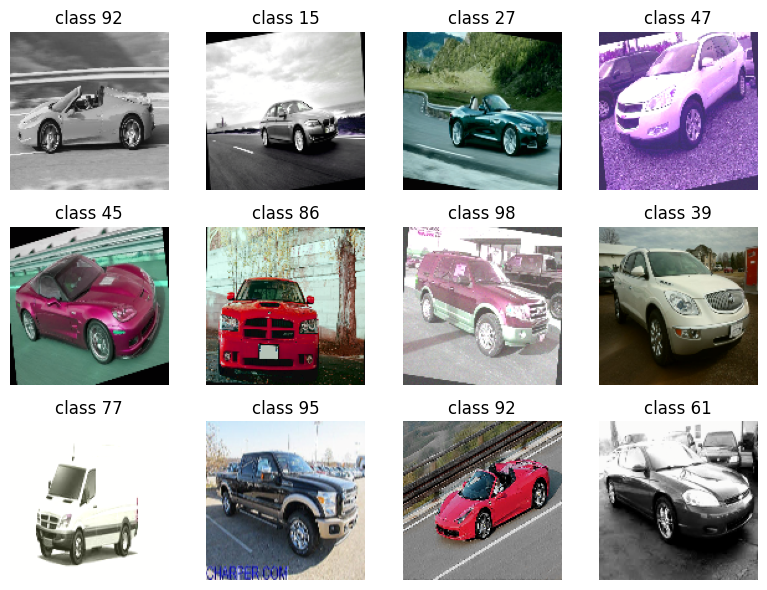

In [86]:
from albumentations.pytorch import ToTensorV2

# Define transforms for training data
train_transform = A.Compose(
    transforms=[
        A.Rotate(
            limit=(-15, 15),
            interpolation=1,
            border_mode=0,
            value=0,
            mask_value=0,
            always_apply=False,
            p=0.5,
        ),
        A.ColorJitter(
            brightness=0.3,
            contrast=0.5,
            saturation=0.5,
            hue=0.2,
            always_apply=False,
            p=0.5,
        ),
        A.ChannelShuffle(p=0.2),
        A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
        A.HueSaturationValue(
            hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5
        ),
        A.ToGray(p=0.2),
        A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), always_apply=False, p=0.2),
        A.GaussianBlur(blur_limit=(3, 7), p=0.1),
        A.MotionBlur(blur_limit=(3, 7), p=0.1),
        A.GaussNoise(var_limit=(10.0, 50.0), mean=50, p=0.1),
        A.Resize(height=HEIGHT, width=WIDTH, always_apply=True),
        A.Normalize(mean=MEAN, std=STD),
        ToTensorV2(),
    ],
    p=1.0,
)

# Prepare the transform
train_transform = AlbumentationsTransform(train_transform)

# Prepare training data
train_data = CarClassification(root="Dataset", csv="Dataset/train.csv", transforms=train_transform)

# Visualize training data
rows = 3
columns = 4
data = train_data
indices = np.random.randint(low=0, high=len(data), size=rows*columns)
print(indices)
train_examples = [data[i] for i in indices]
visualize_image_grid(train_examples, rows, columns)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


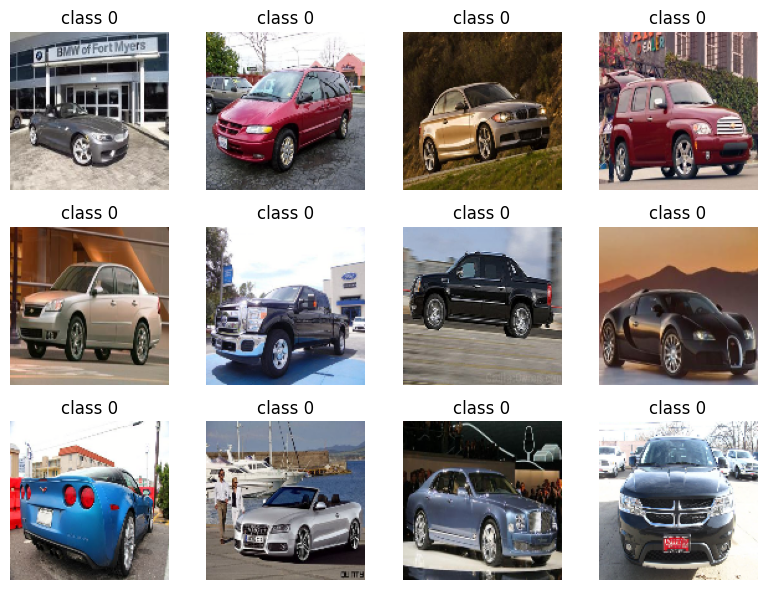

In [87]:

# Prepare testing data
valid_test_transform = A.Compose(
    transforms=[
        A.Resize(height=HEIGHT, width=WIDTH, always_apply=True),
        A.Normalize(mean=MEAN, std=STD),
        ToTensorV2(),
    ],
    p=1.0,
)
valid_test_transform = AlbumentationsTransform(valid_test_transform)
valid_data = CarClassification(root="Dataset", csv="Dataset/SampleSolution.csv", transforms=valid_test_transform)

#Visualize test data
rows = 3
columns = 4
data = valid_data
indices = np.random.randint(low=0, high=len(data), size=rows*columns)
train_examples = [data[i] for i in indices]
visualize_image_grid(train_examples, rows, columns)

In [88]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [89]:
train_loader = DataLoader(train_data, BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_data, BATCH_SIZE, shuffle=False)
model = MLP()
print(model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu");
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

MLP(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)
